In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 5037, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 5037 (delta 188), reused 157 (delta 132), pack-reused 4811
Receiving objects: 100% (5037/5037), 2.79 GiB | 22.93 MiB/s, done.
Resolving deltas: 100% (4014/4014), done.
Updating files: 100% (458/458), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 13.1 MB/s eta 0:00:00


In [3]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 20.0 MB/s eta 0:00:00


In [4]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [5]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBRanker

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/__output__.json
/kaggle/input/training-tuned-models/ials_all.zip
/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_all.zip
/kaggle/input/training-tuned-models/custom.css
/kaggle/input/training-tuned-models/Recsys_Challenge_2023/run_all_algorithms.py


In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
config = {
    'tune_parameters': True,
    'n_trials': 100,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [11]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [12]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [13]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [21]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [22]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [23]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip', 
    '/kaggle/working/slim_recall_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_train_validation.zip', 
    '/kaggle/working/slim_recall_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_all.zip', 
    '/kaggle/working/slim_recall_all.zip', 
)

'/kaggle/working/slim_recall_all.zip'

In [24]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_train = recommender_pure_svd.USER_factors
item_factors_train = recommender_pure_svd.ITEM_factors

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

# recommender_als = ALSImplicitRecommender(URM_train)
# recommender_als.load_model('/kaggle/working/', 'als_xgboost_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 22347 (100.0%), 4623.18 column/sec. Elapsed time 4.83 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 13024 (100.0%), 5294.94 column/sec. Elapsed time 2.46 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2879.54 column/sec. Elapsed time 7.76 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3339.25 column/sec. Elapsed time 6.69 sec
PureSVDRecommender: URM Detected 851 ( 6.5%) users with no inter

In [25]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

print('Merging Models')
result_df, _ = evaluator.evaluateRecommender(hybrid_similarity)
display(result_df)
print('Item KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_item)
display(result_df)
print('RP3 beta')
result_df, _ = evaluator.evaluateRecommender(recommender_rp3)
display(result_df)
print('P3 alpha')
result_df, _ = evaluator.evaluateRecommender(recommender_p3a)
display(result_df)
print('User KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_user)
display(result_df)
print('NMF')
result_df, _ = evaluator.evaluateRecommender(recommender_nmf)
display(result_df)
print('Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd)
display(result_df)
print('Scaled Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_scaled_svd)
display(result_df)
print('Item Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd_item)
display(result_df)
print('SLIM BPR')
result_df, _ = evaluator.evaluateRecommender(recommender_slim_bpr)
display(result_df)
print('SLIM Elastic')
result_df, _ = evaluator.evaluateRecommender(recommender_slim)
display(result_df)
print('EASE R')
result_df, _ = evaluator.evaluateRecommender(recommender_ease_r)
display(result_df)
print('IALS')
result_df, _ = evaluator.evaluateRecommender(recommender_ials)
display(result_df)
# print('ALS')
# result_df, _ = evaluator.evaluateRecommender(recommender_als)
# display(result_df)

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
Merging Models
EvaluatorHoldout: Processed 10456 (100.0%) in 9.69 sec. Users per second: 1079


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.081236,0.139185,0.117504,0.039511,0.068781,0.237517,0.127531,0.09606,0.475899,0.303733,...,0.802826,0.382064,0.802826,0.090882,10.724402,0.998438,0.265776,0.826934,1.502888,0.3873


Item KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 9.34 sec. Users per second: 1119


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079227,0.134354,0.112913,0.038659,0.066899,0.232562,0.124152,0.093117,0.464327,0.297466,...,0.802826,0.372773,0.802826,0.075591,10.416934,0.997963,0.221058,0.803226,1.653431,0.383628


RP3 beta
EvaluatorHoldout: Processed 10456 (100.0%) in 9.52 sec. Users per second: 1098


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079658,0.136429,0.115204,0.038171,0.066535,0.231172,0.124353,0.094189,0.47303,0.294753,...,0.802826,0.37976,0.802826,0.096602,10.808804,0.998526,0.282504,0.833442,1.437561,0.390783


P3 alpha
EvaluatorHoldout: Processed 10456 (100.0%) in 9.20 sec. Users per second: 1137


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.076664,0.128535,0.10787,0.037284,0.064338,0.227507,0.119981,0.089628,0.456676,0.289145,...,0.802826,0.366631,0.802826,0.072251,10.504764,0.998262,0.21129,0.809998,1.371811,0.386528


User KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 12.91 sec. Users per second: 810


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.061448,0.112121,0.096632,0.028523,0.05183,0.190388,0.099346,0.075124,0.40637,0.231987,...,0.802826,0.326244,0.802826,0.011369,7.734762,0.986162,0.033249,0.59641,3.662908,0.323456


NMF
EvaluatorHoldout: Processed 10456 (100.0%) in 11.77 sec. Users per second: 888


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.051415,0.084267,0.069573,0.024792,0.040821,0.165486,0.079928,0.059132,0.338849,0.201455,...,0.802826,0.272036,0.802826,0.018774,9.145243,0.997874,0.054903,0.705169,1.326454,0.362589


Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 11.06 sec. Users per second: 945


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.05022,0.086014,0.072432,0.023883,0.040909,0.164475,0.080074,0.059315,0.344109,0.197553,...,0.802826,0.276259,0.802826,0.005554,7.368601,0.992223,0.016243,0.568176,2.711888,0.326934


Scaled Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 13.64 sec. Users per second: 766


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.052802,0.090327,0.076977,0.025086,0.043651,0.170985,0.084357,0.062638,0.35635,0.206245,...,0.802826,0.286087,0.802826,0.013232,8.625793,0.996729,0.038694,0.665115,1.992554,0.343623


Item Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 14.35 sec. Users per second: 729


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.053395,0.088783,0.074181,0.025534,0.042764,0.173646,0.083816,0.062095,0.355777,0.20946,...,0.802826,0.285627,0.802826,0.018466,9.043891,0.997531,0.054003,0.697354,1.425533,0.361464


SLIM BPR
EvaluatorHoldout: Processed 10456 (100.0%) in 10.31 sec. Users per second: 1014


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.057154,0.100577,0.085625,0.026561,0.047843,0.179969,0.091756,0.068551,0.382269,0.217765,...,0.802826,0.306895,0.802826,0.030224,8.973277,0.994651,0.088387,0.691909,2.634383,0.346626


SLIM Elastic
EvaluatorHoldout: Processed 10456 (100.0%) in 12.69 sec. Users per second: 824


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079839,0.135985,0.114694,0.038588,0.0664,0.233862,0.124583,0.094144,0.472743,0.298541,...,0.802826,0.37953,0.802826,0.053029,10.313128,0.998528,0.155077,0.795222,1.619657,0.371056


EASE R
EvaluatorHoldout: Processed 10456 (100.0%) in 14.88 sec. Users per second: 703


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.07523,0.130395,0.110728,0.036193,0.063731,0.2264,0.119463,0.089591,0.46031,0.284432,...,0.802826,0.369549,0.802826,0.030039,9.477048,0.99708,0.087846,0.730753,2.146813,0.353406


IALS
EvaluatorHoldout: Processed 10456 (100.0%) in 15.37 sec. Users per second: 680


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.069539,0.122979,0.105423,0.032759,0.05783,0.209923,0.11029,0.083801,0.437835,0.260966,...,0.802826,0.351505,0.802826,0.024802,9.523511,0.998258,0.072532,0.734336,1.744761,0.356885


In [26]:
cutoff = 50
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    if user_id == 0:
        print(recommendations)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_19/3291901882.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

[35, 100, 505, 428, 591, 693, 402, 1480, 122, 617, 976, 868, 3, 514, 111, 2, 636, 1545, 256, 341, 336, 1629, 101, 9, 84, 1, 0, 1421, 849, 1287, 1934, 1082, 1213, 53, 28, 288, 1056, 57, 76, 75, 921, 86, 1337, 2498, 772, 136, 283, 533, 97, 155]


,ItemID
UserID,
0,35
0,100
0,505
0,428
0,591
...,...
13023,170
13023,605
13023,6214


In [27]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [28]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,35,False
1,0,100,False
2,0,505,False
3,0,428,False
4,0,591,False
...,...,...,...
651195,13023,170,False
651196,13023,605,True
651197,13023,6214,False
651198,13023,1373,False


In [29]:
training_dataframe.Label.sum()

15808

In [30]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    # 'ALS': recommender_als
}

In [31]:
training_dataframe = training_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        training_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
#         rank = np.argsort(linf_scores[user_id, :])[::-1]
#         positions = np.arange(n_items)[rank]
#         training_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
#         recommendations = pd.Series(rank[:10]).to_frame(name='ItemID')
#         tmp = pd.merge(training_dataframe.loc[user_id, 'ItemID'].to_frame(name='ItemID'), recommendations, on='ItemID', how='left', indicator='Exist')
#         tmp["Recommended"] = tmp["Exist"] == "both"
#         training_dataframe.loc[user_id, f"{label}_Recommended"] = tmp["Recommended"].values
    
    del scores, linf_scores # , rank, positions, tmp
    gc.collect()

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,UserKNN_Score,P3Alpha_Score,RP3Beta_Score,NMF_Score,PureSVD_Score,ScaledSVD_Score,ItemPureSVD_Score,SlimElastic_Score,SlimBPR_Score,EaseR_Score,IALS_Score
0,0,35,False,0.771709,0.010529,0.804430,0.720922,0.052106,0.468605,0.261624,0.087610,0.726071,0.710385,0.698168,0.417650
1,0,100,False,0.550739,0.010197,0.551174,0.527418,0.195079,0.276878,0.271607,0.220367,0.609546,0.903782,0.639627,0.495697
2,0,505,False,0.524022,0.063451,0.354394,0.430191,0.098048,0.088229,0.153259,0.107246,0.545226,0.679032,0.436592,0.363251
3,0,428,False,0.242514,0.005722,0.167343,0.316331,0.029736,0.045883,0.065412,0.058514,0.406289,0.275559,0.387314,0.258930
4,0,591,False,0.513606,0.069904,0.260866,0.259432,0.134287,0.012125,0.050135,0.061455,0.445287,0.318686,0.365680,0.173614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,170,False,0.068760,0.381633,0.081454,0.076387,0.117247,0.167239,0.081350,0.090840,0.095524,0.363909,0.203585,0.135079
651196,13023,605,True,0.057563,0.203670,0.061681,0.063937,0.170859,0.094403,0.147255,0.138972,0.126146,0.371429,0.123425,0.313277
651197,13023,6214,False,0.114844,0.153297,0.252423,0.230385,0.023408,0.021090,0.037629,0.033003,0.108228,0.029598,0.216619,0.240429
651198,13023,1373,False,0.056598,0.234818,0.000000,0.000000,0.092776,0.084519,0.089138,0.096231,0.091869,0.274211,0.252713,0.257621


In [32]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
item_popularity = item_popularity / np.max(item_popularity)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
user_popularity = user_popularity / np.max(user_popularity)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,UserKNN_Score,P3Alpha_Score,RP3Beta_Score,NMF_Score,PureSVD_Score,ScaledSVD_Score,ItemPureSVD_Score,SlimElastic_Score,SlimBPR_Score,EaseR_Score,IALS_Score,item_popularity,user_profile_len,mainstream_user,mainstream_item
0,0,35,False,0.771709,0.010529,0.804430,0.720922,0.052106,0.468605,0.261624,0.087610,0.726071,0.710385,0.698168,0.417650,0.411713,0.033573,77.384713,77.185358
1,0,100,False,0.550739,0.010197,0.551174,0.527418,0.195079,0.276878,0.271607,0.220367,0.609546,0.903782,0.639627,0.495697,0.232476,0.033573,77.384713,90.053545
2,0,505,False,0.524022,0.063451,0.354394,0.430191,0.098048,0.088229,0.153259,0.107246,0.545226,0.679032,0.436592,0.363251,0.079858,0.033573,77.384713,102.144698
3,0,428,False,0.242514,0.005722,0.167343,0.316331,0.029736,0.045883,0.065412,0.058514,0.406289,0.275559,0.387314,0.258930,0.044366,0.033573,77.384713,97.835492
4,0,591,False,0.513606,0.069904,0.260866,0.259432,0.134287,0.012125,0.050135,0.061455,0.445287,0.318686,0.365680,0.173614,0.086069,0.033573,77.384713,86.651586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,170,False,0.068760,0.381633,0.081454,0.076387,0.117247,0.167239,0.081350,0.090840,0.095524,0.363909,0.203585,0.135079,0.173026,0.055156,53.265190,98.486897
651196,13023,605,True,0.057563,0.203670,0.061681,0.063937,0.170859,0.094403,0.147255,0.138972,0.126146,0.371429,0.123425,0.313277,0.079858,0.055156,53.265190,94.862590
651197,13023,6214,False,0.114844,0.153297,0.252423,0.230385,0.023408,0.021090,0.037629,0.033003,0.108228,0.029598,0.216619,0.240429,0.011535,0.055156,53.265190,169.226711
651198,13023,1373,False,0.056598,0.234818,0.000000,0.000000,0.092776,0.084519,0.089138,0.096231,0.091869,0.274211,0.252713,0.257621,0.047915,0.055156,53.265190,112.935230


In [33]:
user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])

training_dataframe = training_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
training_dataframe = training_dataframe.sort_values(by='UserID')
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,UserKNN_Score,P3Alpha_Score,RP3Beta_Score,NMF_Score,PureSVD_Score,ScaledSVD_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,False,0.771709,0.010529,0.804430,0.720922,0.052106,0.468605,0.261624,...,0.070908,0.005731,0.083522,-0.090610,0.014975,0.005684,-0.001896,0.008995,-0.013853,-0.002147
27,0,1421,False,0.273926,0.000823,0.137874,0.166787,0.012335,0.001997,-0.002010,...,0.008304,-0.000813,0.007862,-0.005303,0.004007,0.005684,-0.001896,0.008995,-0.013853,-0.002147
28,0,849,False,0.109069,0.002299,0.063939,0.069627,0.027851,0.031298,0.068452,...,0.007942,-0.005888,0.008819,-0.006112,0.006760,0.005684,-0.001896,0.008995,-0.013853,-0.002147
29,0,1287,False,0.228756,0.068837,0.125857,0.135849,0.052251,0.000109,0.005325,...,0.008537,-0.009985,0.006478,0.003883,-0.011649,0.005684,-0.001896,0.008995,-0.013853,-0.002147
30,0,1934,True,0.111270,0.033073,0.061394,0.132436,0.035119,0.023091,0.050195,...,0.005471,0.001350,0.008471,-0.005479,0.002262,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651193,13023,389,False,0.054072,0.059093,0.086976,0.101711,0.071044,0.011356,0.010958,...,0.011188,-0.017740,-0.005322,-0.011841,-0.004538,0.006896,-0.007143,0.001571,0.006195,0.023549
651176,13023,2195,False,0.096075,0.219686,0.049547,0.057358,0.054811,0.035244,0.083227,...,0.004869,-0.011313,0.006562,-0.000144,0.018232,0.006896,-0.007143,0.001571,0.006195,0.023549
651189,13023,180,False,0.093238,0.026436,0.096624,0.100807,0.028925,-0.008228,0.021380,...,0.028602,-0.007037,-0.013733,0.010851,-0.019142,0.006896,-0.007143,0.001571,0.006195,0.023549
651170,13023,349,False,0.129561,0.353050,0.167004,0.156105,0.150294,0.143994,0.176787,...,0.023461,-0.039074,0.033606,0.036253,0.073695,0.006896,-0.007143,0.001571,0.006195,0.023549


In [34]:
n_estimators = 200
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 32
grow_policy = "depthwise"
objective = "map"  #"pairwise", "ndcg"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(
    objective='rank:{}'.format(objective),
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    max_leaves = int(max_leaves),
    grow_policy = grow_policy,
    verbosity = 1, # 2 if self.verbose else 0,
    booster = booster,
    # enable_categorical = True
)

In [35]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([50, 50, 50, ..., 50, 50, 50])

In [36]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])
# X_train["UserID"] = X_train["UserID"].astype("category")
# X_train["ItemID"] = X_train["ItemID"].astype("category")
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

object_columns = X_train.select_dtypes(include=['object']).columns
X_train[object_columns] = X_train[object_columns].astype('category')

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=32, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=200,
          n_jobs=None, num_parallel_tree=None, objective='rank:map', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

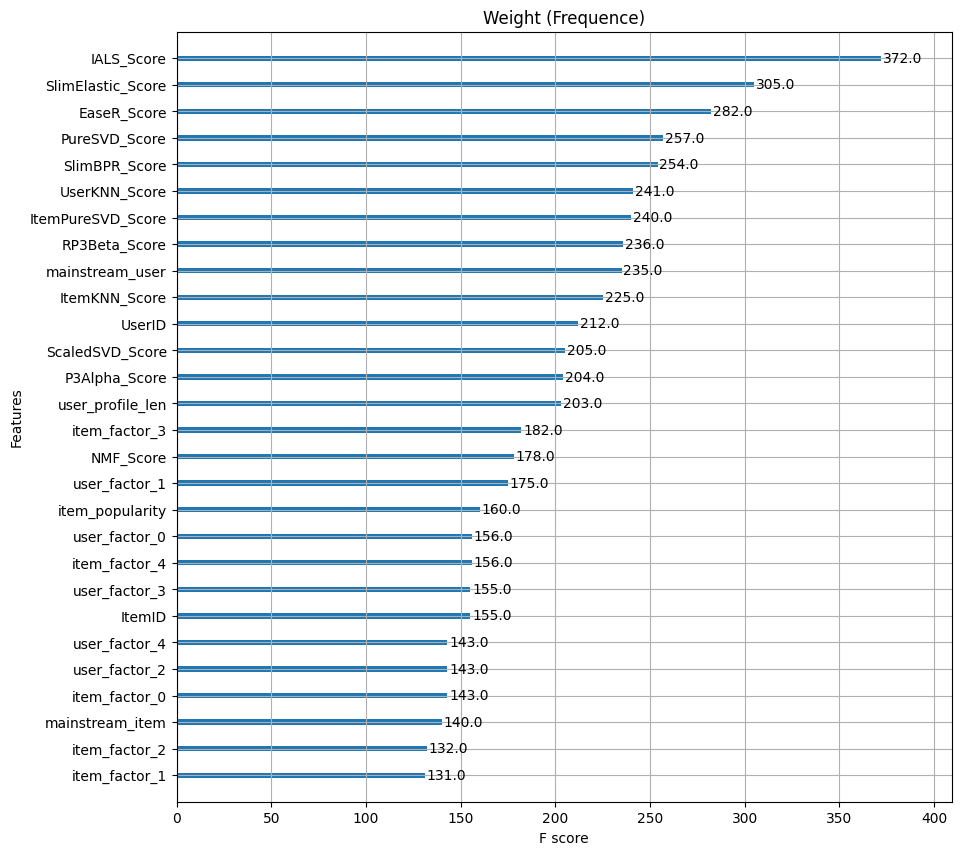

In [37]:
from xgboost import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)', ax=ax)

In [38]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4301.00 column/sec. Elapsed time 5.20 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4580.24 column/sec. Elapsed time 2.84 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2511.64 column/sec. Elapsed time 8.90 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 2991.95 column/sec. Elapsed time 7.47 sec
PureSVDRecommender: URM Detected 627 ( 4.8%) users with no inter

In [39]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    # 'ALS': recommender_als
}

In [40]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        validation_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
#         rank = np.argsort(linf_scores[user_id, :])[::-1]
#         positions = np.arange(n_items)[rank]
#         validation_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
#         recommendations = pd.Series(rank[:10]).to_frame(name='ItemID')
#         tmp = pd.merge(validation_dataframe.loc[user_id, 'ItemID'].to_frame(name='ItemID'), recommendations, on='ItemID', how='left', indicator='Exist')
#         tmp["Recommended"] = tmp["Exist"] == "both"
#         validation_dataframe.loc[user_id, f"{label}_Recommended"] = tmp["Recommended"].values
    
    del scores, linf_scores #, rank, positions, tmp
    gc.collect()
    
validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

/tmp/ipykernel_19/1275237616.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,UserKNN_Score,P3Alpha_Score,RP3Beta_Score,NMF_Score,PureSVD_Score,ScaledSVD_Score,ItemPureSVD_Score,SlimElastic_Score,SlimBPR_Score,EaseR_Score,IALS_Score,item_popularity,user_profile_len
0,0,35,0.942964,0.037371,0.999998,0.999998,0.073441,0.607207,0.336133,0.066994,0.954755,0.948857,0.999998,0.514264,0.406406,0.032075
1,0,100,0.830547,0.033586,0.744487,0.752747,0.238388,0.350097,0.335968,0.352108,0.882033,0.999999,0.926026,0.621994,0.237011,0.032075
2,0,505,0.471617,0.015319,0.288312,0.372304,0.107774,0.104629,0.120161,0.129706,0.573919,0.546931,0.512536,0.371543,0.074733,0.032075
3,0,51,0.213902,0.004863,0.111361,0.149148,0.272648,0.182145,0.168574,0.246363,0.375761,0.783486,0.434108,0.177052,0.202135,0.032075
4,0,402,0.598366,0.013870,0.283639,0.378351,0.070515,0.097070,0.146388,0.105343,0.569258,0.369482,0.449920,0.426898,0.074021,0.032075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,242,0.094612,0.059399,0.057316,0.126628,0.219667,0.055478,0.151109,0.169941,0.158402,0.351669,0.247900,0.307450,0.113879,0.056604
651196,13023,852,0.056650,0.338165,0.000000,0.000000,0.205861,0.105320,0.133431,0.096060,0.106837,0.183125,0.262513,0.274723,0.054093,0.056604
651197,13023,963,0.065047,0.304115,0.000000,0.060471,0.152889,0.115276,0.062147,0.060193,0.165657,0.054292,0.203809,0.339215,0.054804,0.056604
651198,13023,11955,0.260745,0.157063,0.138857,0.242229,0.055549,0.020443,0.093086,0.046719,0.338909,0.031324,0.256101,0.227916,0.004982,0.056604


In [41]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])
validation_dataframe = validation_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe = validation_dataframe.sort_values(by='UserID')

validation_dataframe

,UserID,ItemID,ItemKNN_Score,UserKNN_Score,P3Alpha_Score,RP3Beta_Score,NMF_Score,PureSVD_Score,ScaledSVD_Score,ItemPureSVD_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,0.942964,0.037371,0.999998,0.999998,0.073441,0.607207,0.336133,0.066994,...,0.070908,0.005731,0.083522,-0.090610,0.014975,0.005684,-0.001896,0.008995,-0.013853,-0.002147
27,0,86,0.000000,0.008853,0.000000,0.000000,0.015374,0.079492,0.043844,0.049901,...,0.052802,0.039735,0.028306,-0.087907,-0.017382,0.005684,-0.001896,0.008995,-0.013853,-0.002147
28,0,1082,0.261194,0.003559,0.101984,0.138043,0.058429,0.010421,0.040635,0.041198,...,0.008902,-0.013901,0.005310,0.008307,0.003830,0.005684,-0.001896,0.008995,-0.013853,-0.002147
29,0,636,0.099262,0.008037,0.094083,0.135627,0.046826,0.062618,0.071290,0.056701,...,0.009434,0.000249,0.008939,-0.006449,0.002131,0.005684,-0.001896,0.008995,-0.013853,-0.002147
30,0,1337,0.256143,0.002795,0.077940,0.109506,0.000891,0.004433,0.041649,0.016807,...,0.007159,-0.012959,0.016733,0.007981,0.040655,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651197,13023,963,0.065047,0.304115,0.000000,0.060471,0.152889,0.115276,0.062147,0.060193,...,0.012389,-0.028209,0.014298,-0.001750,0.041015,0.006896,-0.007143,0.001571,0.006195,0.023549
651194,13023,14,0.000000,0.137722,0.000000,0.000000,0.003709,0.057627,0.098057,0.013402,...,0.095542,0.015748,0.113690,-0.135039,0.018867,0.006896,-0.007143,0.001571,0.006195,0.023549
651153,13023,732,0.467619,0.567250,0.406934,0.333082,0.204446,0.159460,0.262585,0.177556,...,0.014192,-0.031852,0.012810,0.008754,0.044532,0.006896,-0.007143,0.001571,0.006195,0.023549
651154,13023,324,0.234817,0.461441,0.229530,0.354057,0.278992,0.161356,0.231662,0.188195,...,0.023976,-0.045454,0.032942,0.022102,0.076070,0.006896,-0.007143,0.001571,0.006195,0.023549


In [42]:
# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

object_columns = validation_dataframe.select_dtypes(include=['object']).columns
validation_dataframe[object_columns] = validation_dataframe[object_columns].astype('category')

In [43]:
class XGBoostRerankerRecommender:
    def __init__(self, URM_train, XGB_model, df):
        self.URM_train = URM_train
        self.df = df
        self.XGB_model = XGB_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.XGB_model.predict(df_slice)
            recommendations.append(items[np.argsort(preds)[-cutoff:][::-1]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [44]:
recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 1.73 min. Users per second: 101


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.097752,0.169919,0.143667,0.049863,0.085496,0.275686,0.154107,0.116344,0.530031,0.366326,...,0.802826,0.425522,0.802826,0.049381,10.026824,0.99725,0.142483,0.772427,1.987474,0.293047


In [45]:
def objective_xgboost(trial):

    XGB_model = XGBRanker(
        objective = trial.suggest_categorical('objective', ["rank:map", "rank:pairwise", "rank:ndcg"]),
        n_estimators = trial.suggest_int('n_estimators', 10, 5000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 20),
        max_leaves = trial.suggest_int('max_leaves', 8, 1024),
        grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        verbosity = 2,
        booster = 'gbtree',
        # tree_method = trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        tree_method = 'hist',
        gamma = trial.suggest_float('gamma', 1e-7, 10, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-7, 1, log=True),
        subsample = trial.suggest_float('subsample', 0.1, 0.9),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9),
        # enable_categorical = True
    )
    
    XGB_model.fit(
        X_train,
        y_train,
        group=groups,
        verbose=True
    )
    
    recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
        
    return result_df.loc[10, 'MAP']

In [46]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_xgboost.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [47]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='xgboost_tuning_fixed', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=config['n_trials'])

[I 2023-12-16 19:10:52,880] A new study created in RDB with name: xgboost_tuning_fixed


EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-16 19:12:49,010] Trial 0 finished with value: 0.04536085455605395 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 18, 'learning_rate': 0.0010513533952415761, 'reg_alpha': 3.66863906296371e-05, 'reg_lambda': 0.025458099416168223, 'max_depth': 11, 'max_leaves': 745, 'grow_policy': 'lossguide', 'gamma': 6.587672980911195e-05, 'min_child_weight': 0.0008007436115633463, 'subsample': 0.39408373473586356, 'colsample_bytree': 0.26647481543652496}. Best is trial 0 with value: 0.04536085455605395.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-16 19:14:52,303] Trial 1 finished with value: 0.04827168042044752 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 54, 'learning_rate': 0.0013488170639318682, 'reg_alpha': 0.00037834455933544024, 'reg_lambda': 1.2339676044405256e-05, 'max_depth': 18, 'max_leaves': 691, 'grow_policy': 'depthwise', 'gamma': 2.024328833115427e-05, 'min_child_weight': 0.0001094757682297069, 'subsample': 0.346812270308991, 'colsample_bytree': 0.203161480332121}. Best is trial 1 with value: 0.04827168042044752.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.78 min. Users per second: 98


[I 2023-12-16 19:16:43,676] Trial 2 finished with value: 0.0489512856596355 and parameters: {'objective': 'rank:map', 'n_estimators': 13, 'learning_rate': 0.0011345149141189573, 'reg_alpha': 6.242578376124819e-05, 'reg_lambda': 0.0006459926263308679, 'max_depth': 17, 'max_leaves': 365, 'grow_policy': 'lossguide', 'gamma': 0.6157730168290332, 'min_child_weight': 2.2718703551643072e-07, 'subsample': 0.7737731263648019, 'colsample_bytree': 0.29040738313202763}. Best is trial 2 with value: 0.0489512856596355.


EvaluatorHoldout: Processed 9000 (86.1%) in 5.48 min. Users per second: 27
EvaluatorHoldout: Processed 10456 (100.0%) in 6.36 min. Users per second: 27


[I 2023-12-16 19:36:30,613] Trial 3 finished with value: 0.039266855970901966 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3918, 'learning_rate': 0.057646510477047726, 'reg_alpha': 0.0016404718516624367, 'reg_lambda': 0.25972571941847417, 'max_depth': 12, 'max_leaves': 905, 'grow_policy': 'lossguide', 'gamma': 0.008726549411741745, 'min_child_weight': 0.0005255671859436582, 'subsample': 0.2856940749575976, 'colsample_bytree': 0.3513831017770954}. Best is trial 2 with value: 0.0489512856596355.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.69 min. Users per second: 103


[I 2023-12-16 19:38:21,675] Trial 4 finished with value: 0.05112604899138994 and parameters: {'objective': 'rank:map', 'n_estimators': 60, 'learning_rate': 0.024654890310293213, 'reg_alpha': 0.2941601617912747, 'reg_lambda': 0.5446933099910206, 'max_depth': 11, 'max_leaves': 30, 'grow_policy': 'depthwise', 'gamma': 0.0006798986363068657, 'min_child_weight': 1.0752499242091786e-05, 'subsample': 0.39196823543628223, 'colsample_bytree': 0.3835988169070701}. Best is trial 4 with value: 0.05112604899138994.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.71 min. Users per second: 64


[I 2023-12-16 19:43:14,869] Trial 5 finished with value: 0.04844718912813848 and parameters: {'objective': 'rank:map', 'n_estimators': 551, 'learning_rate': 0.011477479069257963, 'reg_alpha': 0.9433810865492496, 'reg_lambda': 0.8855488810616259, 'max_depth': 13, 'max_leaves': 621, 'grow_policy': 'depthwise', 'gamma': 0.03553125618044092, 'min_child_weight': 0.013422099838224436, 'subsample': 0.4422361434838106, 'colsample_bytree': 0.7009921513415919}. Best is trial 4 with value: 0.05112604899138994.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.11 min. Users per second: 83


[I 2023-12-16 19:48:02,674] Trial 6 finished with value: 0.04921775755698918 and parameters: {'objective': 'rank:map', 'n_estimators': 1295, 'learning_rate': 0.017610719582407234, 'reg_alpha': 0.6049002165955913, 'reg_lambda': 0.13106338496389472, 'max_depth': 5, 'max_leaves': 437, 'grow_policy': 'lossguide', 'gamma': 6.5182151554751615e-06, 'min_child_weight': 2.7880960525782845e-07, 'subsample': 0.3144452521122797, 'colsample_bytree': 0.8945853511560942}. Best is trial 4 with value: 0.05112604899138994.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.42 min. Users per second: 39


[I 2023-12-16 20:00:00,301] Trial 7 finished with value: 0.04398755632066698 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2285, 'learning_rate': 0.010819600293827192, 'reg_alpha': 0.006799479902239459, 'reg_lambda': 0.4058531551089186, 'max_depth': 10, 'max_leaves': 1007, 'grow_policy': 'lossguide', 'gamma': 0.20020731179949758, 'min_child_weight': 0.00012438483751074864, 'subsample': 0.3400339597867421, 'colsample_bytree': 0.4921189981963011}. Best is trial 4 with value: 0.05112604899138994.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.86 min. Users per second: 94


[I 2023-12-16 20:07:29,397] Trial 8 finished with value: 0.05074632473494426 and parameters: {'objective': 'rank:map', 'n_estimators': 3663, 'learning_rate': 0.0670202484180482, 'reg_alpha': 0.033302321574080224, 'reg_lambda': 5.022472069952093e-05, 'max_depth': 18, 'max_leaves': 465, 'grow_policy': 'lossguide', 'gamma': 9.560443179639913, 'min_child_weight': 0.0005988202334702658, 'subsample': 0.120471990915265, 'colsample_bytree': 0.789520344073434}. Best is trial 4 with value: 0.05112604899138994.


EvaluatorHoldout: Processed 7000 (66.9%) in 5.21 min. Users per second: 22
EvaluatorHoldout: Processed 10456 (100.0%) in 7.79 min. Users per second: 22


[I 2023-12-16 20:31:35,401] Trial 9 finished with value: 0.040029306481583087 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3963, 'learning_rate': 0.0007240036390309052, 'reg_alpha': 3.891250547207314e-05, 'reg_lambda': 0.0005184019205938728, 'max_depth': 12, 'max_leaves': 939, 'grow_policy': 'depthwise', 'gamma': 0.00047197053390506805, 'min_child_weight': 0.149454390191762, 'subsample': 0.8930502600814946, 'colsample_bytree': 0.7839703496157814}. Best is trial 4 with value: 0.05112604899138994.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.68 min. Users per second: 104


[I 2023-12-16 20:33:31,094] Trial 10 finished with value: 0.048709440770698144 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 132, 'learning_rate': 0.4992095980526712, 'reg_alpha': 0.0714215132892986, 'reg_lambda': 0.023306929689757585, 'max_depth': 3, 'max_leaves': 13, 'grow_policy': 'depthwise', 'gamma': 4.37606731895161e-07, 'min_child_weight': 9.251961862679156e-06, 'subsample': 0.59304176499699, 'colsample_bytree': 0.47805979436766777}. Best is trial 4 with value: 0.05112604899138994.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.66 min. Users per second: 105


[I 2023-12-16 20:35:44,448] Trial 11 finished with value: 0.05015538659355656 and parameters: {'objective': 'rank:map', 'n_estimators': 326, 'learning_rate': 0.09986460886341961, 'reg_alpha': 0.04893688571170324, 'reg_lambda': 2.32545891984902e-05, 'max_depth': 20, 'max_leaves': 139, 'grow_policy': 'depthwise', 'gamma': 7.829713652411293, 'min_child_weight': 8.987586265475422e-06, 'subsample': 0.13342938312664687, 'colsample_bytree': 0.6556739229637866}. Best is trial 4 with value: 0.05112604899138994.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.46 min. Users per second: 71


[I 2023-12-16 20:40:50,435] Trial 12 finished with value: 0.05004015693882811 and parameters: {'objective': 'rank:map', 'n_estimators': 926, 'learning_rate': 0.00011653951317113008, 'reg_alpha': 0.0739748601867327, 'reg_lambda': 0.0024781318775996494, 'max_depth': 8, 'max_leaves': 291, 'grow_policy': 'lossguide', 'gamma': 0.0020840439619080543, 'min_child_weight': 0.006023121431986068, 'subsample': 0.1206376804172786, 'colsample_bytree': 0.5659113155017609}. Best is trial 4 with value: 0.05112604899138994.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-16 20:43:03,926] Trial 13 finished with value: 0.04590977231877241 and parameters: {'objective': 'rank:map', 'n_estimators': 147, 'learning_rate': 0.05218830495185223, 'reg_alpha': 0.011366386768685883, 'reg_lambda': 0.0001181735970627411, 'max_depth': 15, 'max_leaves': 188, 'grow_policy': 'depthwise', 'gamma': 0.0017827414129085687, 'min_child_weight': 7.832385060432359e-06, 'subsample': 0.2130990798085893, 'colsample_bytree': 0.12306394273840238}. Best is trial 4 with value: 0.05112604899138994.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.67 min. Users per second: 104


[I 2023-12-16 20:44:54,058] Trial 14 finished with value: 0.04530215050825273 and parameters: {'objective': 'rank:map', 'n_estimators': 60, 'learning_rate': 0.23697109397839486, 'reg_alpha': 0.19505820071139054, 'reg_lambda': 0.011948735582473287, 'max_depth': 7, 'max_leaves': 537, 'grow_policy': 'lossguide', 'gamma': 0.06736722377672191, 'min_child_weight': 0.17896722603860532, 'subsample': 0.523274428829379, 'colsample_bytree': 0.40328524064033533}. Best is trial 4 with value: 0.05112604899138994.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.74 min. Users per second: 100


[I 2023-12-16 20:47:23,424] Trial 15 finished with value: 0.051157127828178585 and parameters: {'objective': 'rank:map', 'n_estimators': 388, 'learning_rate': 0.030611664723620452, 'reg_alpha': 0.01889610652749749, 'reg_lambda': 4.9257406078688605e-05, 'max_depth': 15, 'max_leaves': 108, 'grow_policy': 'depthwise', 'gamma': 6.882279757287022, 'min_child_weight': 0.6961973858904085, 'subsample': 0.20729096484911752, 'colsample_bytree': 0.6392869295267598}. Best is trial 15 with value: 0.051157127828178585.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.78 min. Users per second: 98


[I 2023-12-16 20:49:49,456] Trial 16 finished with value: 0.05100974529699703 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 288, 'learning_rate': 0.027966755887929358, 'reg_alpha': 0.27231940559987333, 'reg_lambda': 0.08531813763044972, 'max_depth': 14, 'max_leaves': 38, 'grow_policy': 'depthwise', 'gamma': 0.00028845722899515063, 'min_child_weight': 0.4393417157068498, 'subsample': 0.23835008735489271, 'colsample_bytree': 0.5798241746055657}. Best is trial 15 with value: 0.051157127828178585.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.34 min. Users per second: 75


[I 2023-12-16 20:53:46,495] Trial 17 finished with value: 0.050557950322440176 and parameters: {'objective': 'rank:map', 'n_estimators': 556, 'learning_rate': 0.005398656583999531, 'reg_alpha': 0.015382759843470147, 'reg_lambda': 0.00458521557519447, 'max_depth': 16, 'max_leaves': 241, 'grow_policy': 'depthwise', 'gamma': 0.0070498065902615484, 'min_child_weight': 0.7230779296346271, 'subsample': 0.469731723219531, 'colsample_bytree': 0.4102250142009085}. Best is trial 15 with value: 0.051157127828178585.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.70 min. Users per second: 103


[I 2023-12-16 20:55:42,235] Trial 18 finished with value: 0.049967558688867715 and parameters: {'objective': 'rank:map', 'n_estimators': 78, 'learning_rate': 0.005125621787248035, 'reg_alpha': 0.0025164378769054452, 'reg_lambda': 0.0005016556126711088, 'max_depth': 9, 'max_leaves': 120, 'grow_policy': 'depthwise', 'gamma': 0.9968422552141449, 'min_child_weight': 0.02468911145785626, 'subsample': 0.2220980167378129, 'colsample_bytree': 0.5387296147077787}. Best is trial 15 with value: 0.051157127828178585.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.68 min. Users per second: 104


[I 2023-12-16 20:57:31,073] Trial 19 finished with value: 0.05035280115616821 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 32, 'learning_rate': 0.0284757079924625, 'reg_alpha': 0.24030096557646446, 'reg_lambda': 0.9509135072454297, 'max_depth': 20, 'max_leaves': 275, 'grow_policy': 'depthwise', 'gamma': 0.0061298789259056005, 'min_child_weight': 0.054695877533725845, 'subsample': 0.5556798675564603, 'colsample_bytree': 0.6307677492056122}. Best is trial 15 with value: 0.051157127828178585.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.74 min. Users per second: 100


[I 2023-12-16 20:59:39,615] Trial 20 finished with value: 0.04423196676018054 and parameters: {'objective': 'rank:map', 'n_estimators': 177, 'learning_rate': 0.1348459083811092, 'reg_alpha': 0.02174717743806847, 'reg_lambda': 0.0001004199507936819, 'max_depth': 6, 'max_leaves': 79, 'grow_policy': 'depthwise', 'gamma': 0.04119310120071384, 'min_child_weight': 0.0034831899743401245, 'subsample': 0.4208184966747428, 'colsample_bytree': 0.5025627089930937}. Best is trial 15 with value: 0.051157127828178585.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.72 min. Users per second: 101


[I 2023-12-16 21:02:00,063] Trial 21 finished with value: 0.05175469996721006 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 299, 'learning_rate': 0.025767355137987318, 'reg_alpha': 0.21545791846885193, 'reg_lambda': 0.09691621283210197, 'max_depth': 14, 'max_leaves': 15, 'grow_policy': 'depthwise', 'gamma': 0.000200609631056212, 'min_child_weight': 0.7921811692236748, 'subsample': 0.23338176979942116, 'colsample_bytree': 0.5872924013514985}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.66 min. Users per second: 105


[I 2023-12-16 21:03:53,986] Trial 22 finished with value: 0.0515395542621543 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 104, 'learning_rate': 0.032151814835022, 'reg_alpha': 0.1480171519364209, 'reg_lambda': 0.08755628639334585, 'max_depth': 14, 'max_leaves': 8, 'grow_policy': 'depthwise', 'gamma': 0.00015768332722218068, 'min_child_weight': 0.09267082686214805, 'subsample': 0.260855436220392, 'colsample_bytree': 0.43598902843425524}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.94 min. Users per second: 90


[I 2023-12-16 21:06:33,510] Trial 23 finished with value: 0.045764200094728556 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 265, 'learning_rate': 0.03686010116268694, 'reg_alpha': 0.12030306670992992, 'reg_lambda': 0.07134806038356577, 'max_depth': 14, 'max_leaves': 176, 'grow_policy': 'depthwise', 'gamma': 6.357523631819677e-05, 'min_child_weight': 0.7951059684543235, 'subsample': 0.17048695128931418, 'colsample_bytree': 0.6044728457266147}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.74 min. Users per second: 100


[I 2023-12-16 21:08:37,965] Trial 24 finished with value: 0.04552319773867253 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 123, 'learning_rate': 0.12550023517709416, 'reg_alpha': 0.03769318629383949, 'reg_lambda': 0.20376574073728856, 'max_depth': 15, 'max_leaves': 110, 'grow_policy': 'depthwise', 'gamma': 0.0001360459762004818, 'min_child_weight': 0.11398462091494836, 'subsample': 0.2752092830521426, 'colsample_bytree': 0.4500233018242187}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.32 min. Users per second: 75


[I 2023-12-16 21:12:13,647] Trial 25 finished with value: 0.0483121182035686 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 408, 'learning_rate': 0.013079097116912278, 'reg_alpha': 0.09100390907267128, 'reg_lambda': 0.08509615130305069, 'max_depth': 16, 'max_leaves': 360, 'grow_policy': 'depthwise', 'gamma': 5.6295314137797755e-06, 'min_child_weight': 0.25506056610321365, 'subsample': 0.236104134054215, 'colsample_bytree': 0.5551257451438395}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.90 min. Users per second: 92


[I 2023-12-16 21:14:45,429] Trial 26 finished with value: 0.046176285963250775 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 217, 'learning_rate': 0.04250907206918077, 'reg_alpha': 0.556094032684668, 'reg_lambda': 0.024574185845220833, 'max_depth': 13, 'max_leaves': 212, 'grow_policy': 'depthwise', 'gamma': 0.00044711175383369803, 'min_child_weight': 0.8194650091392458, 'subsample': 0.1792650347819334, 'colsample_bytree': 0.685150144336943}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.66 min. Users per second: 105


[I 2023-12-16 21:16:40,372] Trial 27 finished with value: 0.0514300515539044 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 110, 'learning_rate': 0.01641862782125994, 'reg_alpha': 0.12297801405146587, 'reg_lambda': 0.05071553603377696, 'max_depth': 18, 'max_leaves': 13, 'grow_policy': 'depthwise', 'gamma': 0.0013690513916515725, 'min_child_weight': 0.04970248976404451, 'subsample': 0.10546384106146062, 'colsample_bytree': 0.5180555415267641}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-16 21:18:49,121] Trial 28 finished with value: 0.0477364405338779 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 103, 'learning_rate': 0.00644492139260967, 'reg_alpha': 0.47732647804967604, 'reg_lambda': 0.04825166159053506, 'max_depth': 18, 'max_leaves': 304, 'grow_policy': 'depthwise', 'gamma': 0.00011708197683532011, 'min_child_weight': 0.05390213541590301, 'subsample': 0.11079158673397092, 'colsample_bytree': 0.45164707101096047}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.64 min. Users per second: 107


[I 2023-12-16 21:20:32,322] Trial 29 finished with value: 0.050921283139627245 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 28, 'learning_rate': 0.003505446321968431, 'reg_alpha': 0.15032913927692365, 'reg_lambda': 0.042326680878616324, 'max_depth': 19, 'max_leaves': 11, 'grow_policy': 'depthwise', 'gamma': 3.949441656304533e-05, 'min_child_weight': 0.0501508699392252, 'subsample': 0.1606119555994098, 'colsample_bytree': 0.3256941397711236}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.97 min. Users per second: 88


[I 2023-12-16 21:23:09,604] Trial 30 finished with value: 0.04870394533100218 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 189, 'learning_rate': 0.018955039007920935, 'reg_alpha': 0.9125889175774922, 'reg_lambda': 0.2053247196240379, 'max_depth': 10, 'max_leaves': 770, 'grow_policy': 'depthwise', 'gamma': 0.0014888324183135158, 'min_child_weight': 0.00259558396941463, 'subsample': 0.2723514015128744, 'colsample_bytree': 0.5233926732794028}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.71 min. Users per second: 102


[I 2023-12-16 21:25:08,405] Trial 31 finished with value: 0.05023085400954616 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 95, 'learning_rate': 0.023329703918088394, 'reg_alpha': 0.11007202136405518, 'reg_lambda': 0.1392337977063083, 'max_depth': 16, 'max_leaves': 87, 'grow_policy': 'depthwise', 'gamma': 0.00018751862434105308, 'min_child_weight': 0.29277524957758766, 'subsample': 0.19957914751832073, 'colsample_bytree': 0.6068512173159327}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.78 min. Users per second: 98


[I 2023-12-16 21:27:19,400] Trial 32 finished with value: 0.04900793650793721 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 149, 'learning_rate': 0.011542744636891287, 'reg_alpha': 0.03373611947999551, 'reg_lambda': 0.012427906883944862, 'max_depth': 14, 'max_leaves': 152, 'grow_policy': 'depthwise', 'gamma': 3.637802932343649e-05, 'min_child_weight': 0.105185517178098, 'subsample': 0.10113191532545579, 'colsample_bytree': 0.5318837352642642}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.78 min. Users per second: 98


[I 2023-12-16 21:29:37,953] Trial 33 finished with value: 0.045660507827206855 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 224, 'learning_rate': 0.0709621833544627, 'reg_alpha': 0.05528590940802247, 'reg_lambda': 0.033767271938437156, 'max_depth': 17, 'max_leaves': 68, 'grow_policy': 'depthwise', 'gamma': 1.2398455942682073e-05, 'min_child_weight': 0.3544252667300213, 'subsample': 0.1738709600152094, 'colsample_bytree': 0.4396348496085104}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.96 min. Users per second: 89


[I 2023-12-16 21:32:32,057] Trial 34 finished with value: 0.04737119114414527 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 426, 'learning_rate': 0.04397301133230338, 'reg_alpha': 0.006622875258818172, 'reg_lambda': 0.0888370291752769, 'max_depth': 17, 'max_leaves': 92, 'grow_policy': 'depthwise', 'gamma': 0.003924833275343661, 'min_child_weight': 0.014465648226370503, 'subsample': 0.3639568260977295, 'colsample_bytree': 0.2481411528809632}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.66 min. Users per second: 105


[I 2023-12-16 21:34:23,495] Trial 35 finished with value: 0.05156020390813871 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 78, 'learning_rate': 0.034036246502448166, 'reg_alpha': 0.17233371733537461, 'reg_lambda': 1.2940486729803019e-05, 'max_depth': 13, 'max_leaves': 19, 'grow_policy': 'depthwise', 'gamma': 0.01612159226675724, 'min_child_weight': 0.7767275854194698, 'subsample': 0.3012660028034977, 'colsample_bytree': 0.49866828958220155}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.66 min. Users per second: 105


[I 2023-12-16 21:36:14,282] Trial 36 finished with value: 0.0512830826987777 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 78, 'learning_rate': 0.07790618561434018, 'reg_alpha': 0.33149597854681295, 'reg_lambda': 0.38153701784729177, 'max_depth': 13, 'max_leaves': 20, 'grow_policy': 'depthwise', 'gamma': 0.0010403485914261459, 'min_child_weight': 0.24359914949770922, 'subsample': 0.3016132739288939, 'colsample_bytree': 0.37798706654816105}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.77 min. Users per second: 99


[I 2023-12-16 21:38:16,231] Trial 37 finished with value: 0.04728524899503329 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 66, 'learning_rate': 0.01829074549111773, 'reg_alpha': 0.16649572569954205, 'reg_lambda': 0.2421728392348114, 'max_depth': 11, 'max_leaves': 782, 'grow_policy': 'depthwise', 'gamma': 0.014628047473617258, 'min_child_weight': 0.07860345217234484, 'subsample': 0.26209459939167834, 'colsample_bytree': 0.485380097338913}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.69 min. Users per second: 103


[I 2023-12-16 21:40:07,655] Trial 38 finished with value: 0.04948751609161947 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 43, 'learning_rate': 0.008954499776700112, 'reg_alpha': 0.41233654486733035, 'reg_lambda': 0.5432941723125346, 'max_depth': 12, 'max_leaves': 218, 'grow_policy': 'lossguide', 'gamma': 0.0006006404800274049, 'min_child_weight': 0.026791826658156177, 'subsample': 0.3228864624179921, 'colsample_bytree': 0.34423569332724346}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.78 min. Users per second: 98


[I 2023-12-16 21:42:14,795] Trial 39 finished with value: 0.04914868883666768 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 99, 'learning_rate': 0.01526214330509745, 'reg_alpha': 0.1746628727367675, 'reg_lambda': 1.4173379193438488e-05, 'max_depth': 10, 'max_leaves': 351, 'grow_policy': 'depthwise', 'gamma': 0.014848462831377189, 'min_child_weight': 0.15064305175811601, 'subsample': 0.3792034939775547, 'colsample_bytree': 0.4205668083549431}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.68 min. Users per second: 104


[I 2023-12-16 21:44:05,816] Trial 40 finished with value: 0.04827850417774923 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 42, 'learning_rate': 0.05094580753952999, 'reg_alpha': 0.8731534989952748, 'reg_lambda': 0.013869050619692368, 'max_depth': 18, 'max_leaves': 161, 'grow_policy': 'lossguide', 'gamma': 0.0038801692160141802, 'min_child_weight': 0.36434781699929586, 'subsample': 0.3269307486499256, 'colsample_bytree': 0.48424191229389585}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.69 min. Users per second: 103


[I 2023-12-16 21:46:00,929] Trial 41 finished with value: 0.050186298441846085 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 93, 'learning_rate': 0.07720179269198835, 'reg_alpha': 0.3612393937046992, 'reg_lambda': 0.3569026984383881, 'max_depth': 12, 'max_leaves': 49, 'grow_policy': 'depthwise', 'gamma': 0.0010646838093699997, 'min_child_weight': 0.9503400752998354, 'subsample': 0.2948909704558921, 'colsample_bytree': 0.37024434873121215}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.64 min. Users per second: 106


[I 2023-12-16 21:47:50,458] Trial 42 finished with value: 0.05160949208170958 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 77, 'learning_rate': 0.03479533481482245, 'reg_alpha': 0.0983051679741153, 'reg_lambda': 0.39287933901265143, 'max_depth': 13, 'max_leaves': 14, 'grow_policy': 'depthwise', 'gamma': 0.0007698505511435662, 'min_child_weight': 0.2131354442641654, 'subsample': 0.3003432405433824, 'colsample_bytree': 0.38707533172331704}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.63 min. Users per second: 107


[I 2023-12-16 21:49:35,871] Trial 43 finished with value: 0.05112702056083901 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 52, 'learning_rate': 0.028999480612108868, 'reg_alpha': 0.09048447672096643, 'reg_lambda': 0.6656066623305738, 'max_depth': 13, 'max_leaves': 9, 'grow_policy': 'depthwise', 'gamma': 0.00027433241116376337, 'min_child_weight': 0.08640065472829735, 'subsample': 0.25509069977911353, 'colsample_bytree': 0.31360323761440934}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.66 min. Users per second: 105


[I 2023-12-16 21:51:19,220] Trial 44 finished with value: 0.04339621209361119 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 11, 'learning_rate': 0.021405892380535817, 'reg_alpha': 0.05796151999933069, 'reg_lambda': 0.1452046752705374, 'max_depth': 14, 'max_leaves': 671, 'grow_policy': 'depthwise', 'gamma': 0.0029086622854591964, 'min_child_weight': 0.18594945164832175, 'subsample': 0.3536921007461241, 'colsample_bytree': 0.45983482065543213}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.74 min. Users per second: 100


[I 2023-12-16 21:53:23,657] Trial 45 finished with value: 0.04753978880509155 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 124, 'learning_rate': 0.03952330188451603, 'reg_alpha': 0.22891618007976028, 'reg_lambda': 0.30725375110581793, 'max_depth': 11, 'max_leaves': 138, 'grow_policy': 'depthwise', 'gamma': 0.0006608780797625618, 'min_child_weight': 0.0290977358423933, 'subsample': 0.13938377570649058, 'colsample_bytree': 0.5194283834107218}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.76 min. Users per second: 99


[I 2023-12-16 21:55:36,235] Trial 46 finished with value: 0.051681221232436465 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 179, 'learning_rate': 0.01399429638158262, 'reg_alpha': 0.11814027646492428, 'reg_lambda': 0.05115066521423554, 'max_depth': 15, 'max_leaves': 60, 'grow_policy': 'depthwise', 'gamma': 9.308258889548872e-05, 'min_child_weight': 0.4036458266204994, 'subsample': 0.4144511697890606, 'colsample_bytree': 0.4042585219995254}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.76 min. Users per second: 99


[I 2023-12-16 21:57:49,337] Trial 47 finished with value: 0.05113642884468301 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 170, 'learning_rate': 0.009959313518373265, 'reg_alpha': 0.03265641723468146, 'reg_lambda': 0.11675582469377374, 'max_depth': 15, 'max_leaves': 69, 'grow_policy': 'lossguide', 'gamma': 0.00012087615272748818, 'min_child_weight': 0.4300833410608086, 'subsample': 0.40129978889164375, 'colsample_bytree': 0.3903849578309917}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.00 min. Users per second: 87


[I 2023-12-16 22:00:31,463] Trial 48 finished with value: 0.045447403936071225 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 222, 'learning_rate': 0.04674601547522101, 'reg_alpha': 0.06432864580529664, 'reg_lambda': 0.5632134567740288, 'max_depth': 13, 'max_leaves': 442, 'grow_policy': 'depthwise', 'gamma': 0.000355561343201181, 'min_child_weight': 0.9991122792322726, 'subsample': 0.3250157916140683, 'colsample_bytree': 0.41959840104662005}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.93 min. Users per second: 90


[I 2023-12-16 22:02:55,694] Trial 49 finished with value: 0.04190065550576307 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 153, 'learning_rate': 0.021111514334105137, 'reg_alpha': 0.6142144684983488, 'reg_lambda': 0.15494228291730644, 'max_depth': 12, 'max_leaves': 524, 'grow_policy': 'depthwise', 'gamma': 7.064877001888666e-05, 'min_child_weight': 0.16714231665083393, 'subsample': 0.4331838617981889, 'colsample_bytree': 0.280635690275133}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-16 22:05:02,831] Trial 50 finished with value: 0.04911755307198176 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 73, 'learning_rate': 0.008130831276996205, 'reg_alpha': 0.2883188119986686, 'reg_lambda': 0.05822285204771043, 'max_depth': 15, 'max_leaves': 585, 'grow_policy': 'depthwise', 'gamma': 0.00022164204364521809, 'min_child_weight': 0.40569391398636273, 'subsample': 0.35952180479370394, 'colsample_bytree': 0.35528766030712927}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.77 min. Users per second: 98


[I 2023-12-16 22:07:07,715] Trial 51 finished with value: 0.051325888682430904 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 118, 'learning_rate': 0.016562178599335127, 'reg_alpha': 0.11314471525917554, 'reg_lambda': 0.03672129685264637, 'max_depth': 16, 'max_leaves': 54, 'grow_policy': 'depthwise', 'gamma': 0.001585928673346903, 'min_child_weight': 0.08155445429756487, 'subsample': 0.2903340192420779, 'colsample_bytree': 0.4738623822176322}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.69 min. Users per second: 103


[I 2023-12-16 22:09:02,111] Trial 52 finished with value: 0.0515002208802425 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 84, 'learning_rate': 0.014635183202279887, 'reg_alpha': 0.14861928874053748, 'reg_lambda': 0.06458892182760849, 'max_depth': 17, 'max_leaves': 9, 'grow_policy': 'depthwise', 'gamma': 0.0008653407999168776, 'min_child_weight': 0.5035968146502051, 'subsample': 0.22840374899695126, 'colsample_bytree': 0.5065235506844625}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 97


[I 2023-12-16 22:11:03,823] Trial 53 finished with value: 0.049776800895058926 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 80, 'learning_rate': 0.02645273397845308, 'reg_alpha': 0.21123823530075211, 'reg_lambda': 0.2467414666023976, 'max_depth': 17, 'max_leaves': 118, 'grow_policy': 'depthwise', 'gamma': 0.0005409789870598563, 'min_child_weight': 0.47856102771903414, 'subsample': 0.22669073735355194, 'colsample_bytree': 0.572391365505671}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.72 min. Users per second: 101


[I 2023-12-16 22:12:56,300] Trial 54 finished with value: 0.05097011209482586 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 54, 'learning_rate': 0.034808233705531946, 'reg_alpha': 0.07348795592489607, 'reg_lambda': 0.07388200145692798, 'max_depth': 14, 'max_leaves': 53, 'grow_policy': 'depthwise', 'gamma': 1.8046724918033523e-05, 'min_child_weight': 0.21433221555307935, 'subsample': 0.2545650969141797, 'colsample_bytree': 0.42145902388176615}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.00 min. Users per second: 87


[I 2023-12-16 22:15:45,545] Trial 55 finished with value: 0.049940176370217255 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 286, 'learning_rate': 0.013727955333629525, 'reg_alpha': 0.19673676523624917, 'reg_lambda': 0.019903182934923304, 'max_depth': 14, 'max_leaves': 189, 'grow_policy': 'depthwise', 'gamma': 0.003111240778078203, 'min_child_weight': 0.5199855332217208, 'subsample': 0.3015593566781534, 'colsample_bytree': 0.3862351243898984}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.75 min. Users per second: 100


[I 2023-12-16 22:17:43,317] Trial 56 finished with value: 0.04998334669241391 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 69, 'learning_rate': 0.058405611198943774, 'reg_alpha': 0.3294557990963112, 'reg_lambda': 0.006460564187510617, 'max_depth': 16, 'max_leaves': 94, 'grow_policy': 'lossguide', 'gamma': 0.000820460498921048, 'min_child_weight': 0.13937642268016734, 'subsample': 0.3869999849976013, 'colsample_bytree': 0.49119671802797843}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.78 min. Users per second: 98


[I 2023-12-16 22:19:53,526] Trial 57 finished with value: 0.05078043213587465 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 159, 'learning_rate': 0.03581146614256608, 'reg_alpha': 0.045361330522599844, 'reg_lambda': 0.09386690430790862, 'max_depth': 13, 'max_leaves': 48, 'grow_policy': 'depthwise', 'gamma': 0.0002595046669318998, 'min_child_weight': 0.5492100583788949, 'subsample': 0.194903827173302, 'colsample_bytree': 0.44721206759048954}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-16 22:22:04,745] Trial 58 finished with value: 0.050901737894852535 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 127, 'learning_rate': 0.01282750812802328, 'reg_alpha': 0.025229282164209003, 'reg_lambda': 0.0019633996002466894, 'max_depth': 15, 'max_leaves': 134, 'grow_policy': 'depthwise', 'gamma': 8.330961142415321e-05, 'min_child_weight': 0.2610621994413795, 'subsample': 0.34141806928979257, 'colsample_bytree': 0.5507188301464205}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.70 min. Users per second: 103


[I 2023-12-16 22:23:58,277] Trial 59 finished with value: 0.051464523293378014 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 88, 'learning_rate': 0.024224770184011042, 'reg_alpha': 0.10044194226418832, 'reg_lambda': 0.03125782486407119, 'max_depth': 3, 'max_leaves': 36, 'grow_policy': 'depthwise', 'gamma': 4.3823595603428885e-05, 'min_child_weight': 0.9243874156091474, 'subsample': 0.2386774038109746, 'colsample_bytree': 0.5027176566063468}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.89 min. Users per second: 92


[I 2023-12-16 22:26:24,206] Trial 60 finished with value: 0.0389040392999847 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 190, 'learning_rate': 0.09432250585420825, 'reg_alpha': 0.5587422590625464, 'reg_lambda': 0.167516038640895, 'max_depth': 12, 'max_leaves': 255, 'grow_policy': 'depthwise', 'gamma': 0.00013586039956591222, 'min_child_weight': 0.5366597928965494, 'subsample': 0.45608577235692466, 'colsample_bytree': 0.5814892247094177}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.71 min. Users per second: 102


[I 2023-12-16 22:28:19,732] Trial 61 finished with value: 0.050969447936022746 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 88, 'learning_rate': 0.027451647518952463, 'reg_alpha': 0.12907138752127606, 'reg_lambda': 0.03587705326101616, 'max_depth': 5, 'max_leaves': 42, 'grow_policy': 'depthwise', 'gamma': 5.692567934657246e-05, 'min_child_weight': 0.2822676381816017, 'subsample': 0.23347900200768607, 'colsample_bytree': 0.5092772637373929}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.75 min. Users per second: 100


[I 2023-12-16 22:30:23,469] Trial 62 finished with value: 0.05066699760751082 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 110, 'learning_rate': 0.02277995207246944, 'reg_alpha': 0.08453927619276383, 'reg_lambda': 0.06076395380647353, 'max_depth': 9, 'max_leaves': 87, 'grow_policy': 'depthwise', 'gamma': 3.6502020228356286e-05, 'min_child_weight': 0.8970689205636425, 'subsample': 0.27056811121332053, 'colsample_bytree': 0.4699374829761903}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.68 min. Users per second: 104


[I 2023-12-16 22:32:14,217] Trial 63 finished with value: 0.051146987072054464 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 63, 'learning_rate': 0.03359907374985432, 'reg_alpha': 0.16255794511203472, 'reg_lambda': 0.11072706002316074, 'max_depth': 19, 'max_leaves': 8, 'grow_policy': 'depthwise', 'gamma': 0.00036607135726187637, 'min_child_weight': 0.6125100427216679, 'subsample': 0.2099488864991606, 'colsample_bytree': 0.4312027611203264}. Best is trial 21 with value: 0.05175469996721006.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.68 min. Users per second: 104


[I 2023-12-16 22:34:11,554] Trial 64 finished with value: 0.05188971775907559 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 137, 'learning_rate': 0.06005822126710328, 'reg_alpha': 0.04792772456672987, 'reg_lambda': 0.029778685587951114, 'max_depth': 3, 'max_leaves': 115, 'grow_policy': 'depthwise', 'gamma': 0.00017148301986888472, 'min_child_weight': 0.13177072723138886, 'subsample': 0.2441900171836821, 'colsample_bytree': 0.5425445097984052}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.69 min. Users per second: 103


[I 2023-12-16 22:36:10,709] Trial 65 finished with value: 0.051365852066407314 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 133, 'learning_rate': 0.05534153042710217, 'reg_alpha': 0.044261254502989573, 'reg_lambda': 0.01727641454799445, 'max_depth': 4, 'max_leaves': 185, 'grow_policy': 'depthwise', 'gamma': 0.0009028567384509449, 'min_child_weight': 0.13096177226873842, 'subsample': 0.28670356095765137, 'colsample_bytree': 0.5433083860045803}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-16 22:38:38,147] Trial 66 finished with value: 0.04795919560121995 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 257, 'learning_rate': 0.055576902120331194, 'reg_alpha': 0.23196229558203804, 'reg_lambda': 0.057290200559162785, 'max_depth': 7, 'max_leaves': 112, 'grow_policy': 'depthwise', 'gamma': 0.00020436138863833827, 'min_child_weight': 0.07080788348412907, 'subsample': 0.31225617206254586, 'colsample_bytree': 0.39851191646054335}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.76 min. Users per second: 99


[I 2023-12-16 22:40:46,325] Trial 67 finished with value: 0.0423613615938603 and parameters: {'objective': 'rank:map', 'n_estimators': 149, 'learning_rate': 0.13744362464648108, 'reg_alpha': 0.06519532417089419, 'reg_lambda': 0.02205739576360505, 'max_depth': 13, 'max_leaves': 77, 'grow_policy': 'depthwise', 'gamma': 0.0019619489585488794, 'min_child_weight': 0.03608115246196637, 'subsample': 0.18940300259869203, 'colsample_bytree': 0.5974279948611114}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.46 min. Users per second: 71


[I 2023-12-16 22:44:56,333] Trial 68 finished with value: 0.047169768857556346 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 330, 'learning_rate': 0.010537579531733798, 'reg_alpha': 0.14016702514749796, 'reg_lambda': 0.21434079868862643, 'max_depth': 15, 'max_leaves': 860, 'grow_policy': 'lossguide', 'gamma': 0.00041984397188349045, 'min_child_weight': 0.20560720987152364, 'subsample': 0.16054323665274603, 'colsample_bytree': 0.5478818157209463}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.87 min. Users per second: 93


[I 2023-12-16 22:47:20,741] Trial 69 finished with value: 0.050354231943989615 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 190, 'learning_rate': 0.017992954785631676, 'reg_alpha': 0.3090875258298019, 'reg_lambda': 0.1030110411948945, 'max_depth': 14, 'max_leaves': 144, 'grow_policy': 'depthwise', 'gamma': 0.0001018021834098272, 'min_child_weight': 0.014721085300628694, 'subsample': 0.255144161677223, 'colsample_bytree': 0.4720312660040695}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.73 min. Users per second: 101


[I 2023-12-16 22:49:21,242] Trial 70 finished with value: 0.050966370034369726 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 105, 'learning_rate': 0.03975750678857329, 'reg_alpha': 0.03013555246440321, 'reg_lambda': 0.028279576287534258, 'max_depth': 16, 'max_leaves': 33, 'grow_policy': 'depthwise', 'gamma': 0.00016053522189231058, 'min_child_weight': 0.10115128456326243, 'subsample': 0.20758699430967864, 'colsample_bytree': 0.6260083327563728}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.71 min. Users per second: 102


[I 2023-12-16 22:51:15,380] Trial 71 finished with value: 0.05138270272403841 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 85, 'learning_rate': 0.026977164306654405, 'reg_alpha': 0.10874868530515612, 'reg_lambda': 0.04177108237696571, 'max_depth': 3, 'max_leaves': 37, 'grow_policy': 'depthwise', 'gamma': 2.7491873319038256e-05, 'min_child_weight': 0.2941249912261508, 'subsample': 0.2365664443544237, 'colsample_bytree': 0.5152234357152361}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.71 min. Users per second: 102


[I 2023-12-16 22:53:09,398] Trial 72 finished with value: 0.05138003090805363 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 86, 'learning_rate': 0.021506745454936697, 'reg_alpha': 0.09378707522886573, 'reg_lambda': 0.07387048138231116, 'max_depth': 3, 'max_leaves': 69, 'grow_policy': 'depthwise', 'gamma': 5.715771321768573e-05, 'min_child_weight': 0.6338332205624544, 'subsample': 0.2695149326082122, 'colsample_bytree': 0.49670507963481947}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.72 min. Users per second: 101


[I 2023-12-16 22:55:12,056] Trial 73 finished with value: 0.05157408672471841 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 137, 'learning_rate': 0.01429188174830408, 'reg_alpha': 0.05212829652754735, 'reg_lambda': 0.02721418187885011, 'max_depth': 4, 'max_leaves': 106, 'grow_policy': 'depthwise', 'gamma': 1.3261035903020796e-05, 'min_child_weight': 0.9307215852747752, 'subsample': 0.23876377449156297, 'colsample_bytree': 0.44511767582421236}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.71 min. Users per second: 102


[I 2023-12-16 22:57:15,014] Trial 74 finished with value: 0.051514126467981286 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 145, 'learning_rate': 0.013973964539588086, 'reg_alpha': 0.04192999123039636, 'reg_lambda': 0.01655890244248301, 'max_depth': 4, 'max_leaves': 109, 'grow_policy': 'depthwise', 'gamma': 8.317582469356478e-06, 'min_child_weight': 0.35615926470366244, 'subsample': 0.3347993603410874, 'colsample_bytree': 0.44247722368390574}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.74 min. Users per second: 100


[I 2023-12-16 22:59:28,702] Trial 75 finished with value: 0.05156200662488976 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 221, 'learning_rate': 0.007294784112098316, 'reg_alpha': 0.020213331032130653, 'reg_lambda': 0.011496099651222808, 'max_depth': 4, 'max_leaves': 232, 'grow_policy': 'depthwise', 'gamma': 7.165068832450529e-06, 'min_child_weight': 0.33286092868509, 'subsample': 0.3352755282212209, 'colsample_bytree': 0.43922341713440727}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.75 min. Users per second: 100


[I 2023-12-16 23:01:44,455] Trial 76 finished with value: 0.05158925990697278 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 233, 'learning_rate': 0.007494531317757999, 'reg_alpha': 0.017094230182895617, 'reg_lambda': 0.00774704888305646, 'max_depth': 4, 'max_leaves': 193, 'grow_policy': 'depthwise', 'gamma': 2.6932607978748183e-06, 'min_child_weight': 0.1377136220158929, 'subsample': 0.30632409759644763, 'colsample_bytree': 0.4068632752408604}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.76 min. Users per second: 99


[I 2023-12-16 23:04:00,770] Trial 77 finished with value: 0.051476443995094066 and parameters: {'objective': 'rank:map', 'n_estimators': 229, 'learning_rate': 0.004901894818285344, 'reg_alpha': 0.016228300321427504, 'reg_lambda': 0.009765508692525349, 'max_depth': 4, 'max_leaves': 323, 'grow_policy': 'depthwise', 'gamma': 3.037595913550069e-06, 'min_child_weight': 0.15208817148993553, 'subsample': 0.3132957578142703, 'colsample_bytree': 0.40969063485872903}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 96


[I 2023-12-16 23:06:34,652] Trial 78 finished with value: 0.05148177244629105 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 331, 'learning_rate': 0.009944121210342556, 'reg_alpha': 0.021140526685047963, 'reg_lambda': 0.010124781835103031, 'max_depth': 5, 'max_leaves': 222, 'grow_policy': 'depthwise', 'gamma': 2.516486321924421e-06, 'min_child_weight': 0.2260546191610455, 'subsample': 0.3682025200845156, 'colsample_bytree': 0.4608470300375154}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.77 min. Users per second: 98


[I 2023-12-16 23:08:47,431] Trial 79 finished with value: 0.051465441730122956 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 191, 'learning_rate': 0.006499071571784349, 'reg_alpha': 0.011608907350581553, 'reg_lambda': 0.023751201323478986, 'max_depth': 5, 'max_leaves': 168, 'grow_policy': 'depthwise', 'gamma': 1.9977988900881523e-05, 'min_child_weight': 0.0675434264073818, 'subsample': 0.40511347679862364, 'colsample_bytree': 0.3468676241891178}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.92 min. Users per second: 91


[I 2023-12-16 23:11:45,309] Trial 80 finished with value: 0.05162999751035394 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 470, 'learning_rate': 0.007986294575672867, 'reg_alpha': 0.05609233846221578, 'reg_lambda': 0.008014469872191224, 'max_depth': 6, 'max_leaves': 278, 'grow_policy': 'lossguide', 'gamma': 1.1969078129115855e-05, 'min_child_weight': 0.04758863057691017, 'subsample': 0.34498717721654754, 'colsample_bytree': 0.3679394128916808}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.90 min. Users per second: 92


[I 2023-12-16 23:14:36,621] Trial 81 finished with value: 0.05153184622484615 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 425, 'learning_rate': 0.007091205664129033, 'reg_alpha': 0.05254640246177315, 'reg_lambda': 0.007377962242819358, 'max_depth': 6, 'max_leaves': 268, 'grow_policy': 'lossguide', 'gamma': 1.3965540833800973e-05, 'min_child_weight': 0.042684341936830114, 'subsample': 0.3372005550917034, 'colsample_bytree': 0.3748059108578274}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 96


[I 2023-12-16 23:17:28,896] Trial 82 finished with value: 0.05151277158402313 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 535, 'learning_rate': 0.0044267229885398916, 'reg_alpha': 0.029491736885107894, 'reg_lambda': 0.0036157064885503297, 'max_depth': 4, 'max_leaves': 218, 'grow_policy': 'lossguide', 'gamma': 7.955839489332178e-06, 'min_child_weight': 0.11793116233016539, 'subsample': 0.2974968846683713, 'colsample_bytree': 0.4136540541078729}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-16 23:19:54,527] Trial 83 finished with value: 0.05140313983920593 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 265, 'learning_rate': 0.00904564033935275, 'reg_alpha': 0.03948328348293689, 'reg_lambda': 0.026057251563414836, 'max_depth': 6, 'max_leaves': 387, 'grow_policy': 'lossguide', 'gamma': 4.455979059830656e-06, 'min_child_weight': 0.30680341281822576, 'subsample': 0.3785868437562602, 'colsample_bytree': 0.39076071295835635}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.71 min. Users per second: 102


[I 2023-12-16 23:22:03,554] Trial 84 finished with value: 0.051145829538140716 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 232, 'learning_rate': 0.011116736299520497, 'reg_alpha': 0.020132961779064536, 'reg_lambda': 0.013501351202851808, 'max_depth': 3, 'max_leaves': 193, 'grow_policy': 'lossguide', 'gamma': 1.353818212994143e-06, 'min_child_weight': 0.7194953894703451, 'subsample': 0.2825805259179993, 'colsample_bytree': 0.36850328530971405}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.72 min. Users per second: 101


[I 2023-12-16 23:24:06,763] Trial 85 finished with value: 0.05132178987381797 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 166, 'learning_rate': 0.0075850120933878065, 'reg_alpha': 0.06976519124090749, 'reg_lambda': 0.016943460312155562, 'max_depth': 4, 'max_leaves': 295, 'grow_policy': 'lossguide', 'gamma': 2.5872431964402465e-05, 'min_child_weight': 0.3642767372255275, 'subsample': 0.3521794191002424, 'colsample_bytree': 0.3243377595977061}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 96


[I 2023-12-16 23:26:45,278] Trial 86 finished with value: 0.05177999872481566 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 365, 'learning_rate': 0.0030703921981552634, 'reg_alpha': 0.05103301028242043, 'reg_lambda': 0.006446360638605481, 'max_depth': 5, 'max_leaves': 244, 'grow_policy': 'depthwise', 'gamma': 1.6889311887132132e-05, 'min_child_weight': 0.1784923165293976, 'subsample': 0.31203130187842415, 'colsample_bytree': 0.43138261201465966}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 96


[I 2023-12-16 23:29:23,762] Trial 87 finished with value: 0.05177638190573422 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 360, 'learning_rate': 0.0041579189636148945, 'reg_alpha': 0.02683149023997358, 'reg_lambda': 0.005454939400321297, 'max_depth': 5, 'max_leaves': 161, 'grow_policy': 'depthwise', 'gamma': 2.9891120500879036e-05, 'min_child_weight': 0.057226959138363266, 'subsample': 0.4120610288235913, 'colsample_bytree': 0.4373641983467559}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.90 min. Users per second: 92


[I 2023-12-16 23:32:11,021] Trial 88 finished with value: 0.05156263283176126 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 366, 'learning_rate': 0.003199978377318916, 'reg_alpha': 0.05361658544698615, 'reg_lambda': 0.006472768565353216, 'max_depth': 6, 'max_leaves': 160, 'grow_policy': 'depthwise', 'gamma': 1.2162941390982203e-05, 'min_child_weight': 0.05571438990068202, 'subsample': 0.4083901955718442, 'colsample_bytree': 0.40458761223535067}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.89 min. Users per second: 92


[I 2023-12-16 23:34:51,340] Trial 89 finished with value: 0.05136622399533702 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 295, 'learning_rate': 0.005437694043917773, 'reg_alpha': 0.02883855506537306, 'reg_lambda': 0.00796693877660483, 'max_depth': 7, 'max_leaves': 122, 'grow_policy': 'lossguide', 'gamma': 3.06624587719396e-05, 'min_child_weight': 0.020388611862448575, 'subsample': 0.4312159979347009, 'colsample_bytree': 0.4560615231006519}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.89 min. Users per second: 92


[I 2023-12-16 23:38:00,777] Trial 90 finished with value: 0.05144993077567736 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 601, 'learning_rate': 0.0025821049195685706, 'reg_alpha': 0.08113467644108466, 'reg_lambda': 0.04249006181815491, 'max_depth': 5, 'max_leaves': 254, 'grow_policy': 'depthwise', 'gamma': 8.238756833879444e-05, 'min_child_weight': 0.041139754683705405, 'subsample': 0.47594690949162477, 'colsample_bytree': 0.4276077202676453}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.86 min. Users per second: 94


[I 2023-12-16 23:40:46,598] Trial 91 finished with value: 0.05160534393558554 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 366, 'learning_rate': 0.0028550684149157685, 'reg_alpha': 0.05522393157708143, 'reg_lambda': 0.0048268471094567176, 'max_depth': 6, 'max_leaves': 162, 'grow_policy': 'depthwise', 'gamma': 1.3463107020650698e-05, 'min_child_weight': 0.06202590428504047, 'subsample': 0.402239454677065, 'colsample_bytree': 0.40439550153431514}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.04 min. Users per second: 85


[I 2023-12-16 23:44:07,117] Trial 92 finished with value: 0.051477214419305695 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 505, 'learning_rate': 0.0023349663315666274, 'reg_alpha': 0.039235440260402876, 'reg_lambda': 0.00511035788007354, 'max_depth': 7, 'max_leaves': 203, 'grow_policy': 'depthwise', 'gamma': 1.922774840432349e-05, 'min_child_weight': 0.1671154130799338, 'subsample': 0.37517241480771424, 'colsample_bytree': 0.35221908462371654}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-16 23:46:48,818] Trial 93 finished with value: 0.051770503151528924 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 374, 'learning_rate': 0.0037352809547742736, 'reg_alpha': 0.058132570740712125, 'reg_lambda': 0.0025401763730578536, 'max_depth': 5, 'max_leaves': 143, 'grow_policy': 'depthwise', 'gamma': 4.963680799201061e-05, 'min_child_weight': 0.10314590943992638, 'subsample': 0.39255574457113096, 'colsample_bytree': 0.3962861663310285}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.02 min. Users per second: 86


[I 2023-12-16 23:49:51,232] Trial 94 finished with value: 0.05101760514203195 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 371, 'learning_rate': 0.0040672239739795325, 'reg_alpha': 0.06898785944351128, 'reg_lambda': 0.002444508541567381, 'max_depth': 8, 'max_leaves': 161, 'grow_policy': 'depthwise', 'gamma': 4.698839526806623e-05, 'min_child_weight': 0.09864362655190537, 'subsample': 0.3975027904106131, 'colsample_bytree': 0.3888472358095263}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-16 23:52:26,889] Trial 95 finished with value: 0.05155781293644791 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 306, 'learning_rate': 0.005821061538169794, 'reg_alpha': 0.03505713932435329, 'reg_lambda': 0.0033094879533274637, 'max_depth': 6, 'max_leaves': 323, 'grow_policy': 'depthwise', 'gamma': 8.015445022268045e-05, 'min_child_weight': 0.06636354688134673, 'subsample': 0.4129548800552933, 'colsample_bytree': 0.3627637317395846}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.86 min. Users per second: 94


[I 2023-12-16 23:55:21,620] Trial 96 finished with value: 0.051576595347397475 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 456, 'learning_rate': 0.0018436119720341702, 'reg_alpha': 0.014530092990276765, 'reg_lambda': 0.0038139948265895965, 'max_depth': 5, 'max_leaves': 135, 'grow_policy': 'depthwise', 'gamma': 2.8562725618116254e-05, 'min_child_weight': 0.0324286588036434, 'subsample': 0.3584820332663022, 'colsample_bytree': 0.40049550325341554}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.91 min. Users per second: 91


[I 2023-12-16 23:58:44,905] Trial 97 finished with value: 0.051417584344373324 and parameters: {'objective': 'rank:map', 'n_estimators': 657, 'learning_rate': 0.0038529615270341917, 'reg_alpha': 0.0909119561707636, 'reg_lambda': 0.004670964674493839, 'max_depth': 5, 'max_leaves': 240, 'grow_policy': 'depthwise', 'gamma': 0.00011209551425407204, 'min_child_weight': 0.020788497028518222, 'subsample': 0.3855500190654875, 'colsample_bytree': 0.3366920082169789}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-17 00:01:26,630] Trial 98 finished with value: 0.051624650083191205 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 374, 'learning_rate': 0.004706035017352091, 'reg_alpha': 0.024381831337710713, 'reg_lambda': 0.0025823799907836826, 'max_depth': 5, 'max_leaves': 179, 'grow_policy': 'depthwise', 'gamma': 5.16056855907575e-05, 'min_child_weight': 0.11594811682947613, 'subsample': 0.42413055004521555, 'colsample_bytree': 0.3774217710407592}. Best is trial 64 with value: 0.05188971775907559.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.05 min. Users per second: 85


[I 2023-12-17 00:04:27,890] Trial 99 finished with value: 0.051073371710327074 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 354, 'learning_rate': 0.003141853631981159, 'reg_alpha': 0.023326083493549976, 'reg_lambda': 0.001829349173075686, 'max_depth': 8, 'max_leaves': 276, 'grow_policy': 'depthwise', 'gamma': 0.00024224614964134426, 'min_child_weight': 0.009225621490112081, 'subsample': 0.42384241715611437, 'colsample_bytree': 0.30302869034220986}. Best is trial 64 with value: 0.05188971775907559.


In [48]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [49]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [50]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [51]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_hybrid_xgboost.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_hybrid_xgboost.json', 
            'tuning_results/best_params_hybrid_xgboost.json', 
            'XGBoost tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/xgboost/best_params_hybrid_xgboost.json', 
        '/kaggle/working/best_params_hybrid_xgboost.json'
    )

In [52]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_xgboost.db', 
        'Xgboost tuning db updated results (from kaggle notebook)'
    )

In [53]:
with open('/kaggle/working/best_params_hybrid_xgboost.json', 'r') as params_file:
    xgboost_params = json.load(params_file)
xgboost_params['tree_method'] = 'hist'
xgboost_params['booster'] = 'gbtree'
xgboost_params

{'objective': 'rank:ndcg',
 'n_estimators': 137,
 'learning_rate': 0.06005822126710328,
 'reg_alpha': 0.04792772456672987,
 'reg_lambda': 0.029778685587951114,
 'max_depth': 3,
 'max_leaves': 115,
 'grow_policy': 'depthwise',
 'gamma': 0.00017148301986888472,
 'min_child_weight': 0.13177072723138886,
 'subsample': 0.2441900171836821,
 'colsample_bytree': 0.5425445097984052,
 'tree_method': 'hist',
 'booster': 'gbtree'}

In [54]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_final_train = recommender_pure_svd.USER_factors
item_factors_final_train = recommender_pure_svd.ITEM_factors

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_recall_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4563.35 column/sec. Elapsed time 4.90 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4799.55 column/sec. Elapsed time 2.71 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2520.68 column/sec. Elapsed time 8.87 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3023.88 column/sec. Elapsed time 7.39 sec
PureSVDRecommender: URM Detected 627 ( 4.8%) users with no inter

In [55]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    # 'ALS': recommender_als
}

In [56]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = final_train_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        final_train_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
#         rank = np.argsort(linf_scores[user_id, :])[::-1]
#         positions = np.arange(n_items)[rank]
#         final_train_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
#         recommendations = pd.Series(rank[:10]).to_frame(name='ItemID')
#         tmp = pd.merge(final_train_dataframe.loc[user_id, 'ItemID'].to_frame(name='ItemID'), recommendations, on='ItemID', how='left', indicator='Exist')
#         tmp["Recommended"] = tmp["Exist"] == "both"
#         final_train_dataframe.loc[user_id, f"{label}_Recommended"] = tmp["Recommended"].values
    
    del scores, linf_scores #, rank, positions, tmp
    gc.collect()

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
final_train_dataframe['mainstream_item'] = mainstream_item[final_train_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

final_train_dataframe = final_train_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe = final_train_dataframe.sort_values(by='UserID')
final_train_dataframe

/tmp/ipykernel_19/3358759058.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,UserKNN_Score,P3Alpha_Score,RP3Beta_Score,NMF_Score,PureSVD_Score,ScaledSVD_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,False,0.942964,0.037371,0.999998,0.999998,0.073441,0.576384,0.325416,...,0.069509,0.012298,0.084060,-0.077164,0.016836,0.005573,0.000276,0.007794,-0.010626,-0.001530
27,0,86,False,0.000000,0.008853,0.000000,0.000000,0.015374,0.060529,0.059934,...,0.052684,0.052133,0.027592,-0.095366,-0.011944,0.005573,0.000276,0.007794,-0.010626,-0.001530
28,0,1082,False,0.261194,0.003559,0.101984,0.138043,0.058429,0.010300,0.042444,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
29,0,636,False,0.099262,0.008037,0.094083,0.135627,0.046826,0.057875,0.068249,...,0.009143,0.000777,0.011283,-0.008494,0.002114,0.005573,0.000276,0.007794,-0.010626,-0.001530
30,0,1337,False,0.256143,0.002795,0.077940,0.109506,0.000891,0.002771,0.035983,...,0.008009,-0.013008,0.019273,0.015060,0.043675,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651197,13023,963,False,0.065047,0.304115,0.000000,0.060471,0.152889,0.110313,0.088629,...,0.012542,-0.028591,0.021119,0.003770,0.045804,0.009693,-0.007923,-0.000422,0.004503,0.023066
651194,13023,14,False,0.000000,0.137722,0.000000,0.000000,0.003709,0.067306,0.145068,...,0.096477,0.024090,0.105299,-0.131160,0.008674,0.009693,-0.007923,-0.000422,0.004503,0.023066
651153,13023,732,False,0.467619,0.567250,0.406934,0.333082,0.204446,0.158589,0.252762,...,0.016157,-0.035325,0.015268,0.016982,0.054950,0.009693,-0.007923,-0.000422,0.004503,0.023066
651154,13023,324,False,0.234817,0.461441,0.229530,0.354057,0.278992,0.159574,0.222526,...,0.024626,-0.042593,0.041388,0.035765,0.073477,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [57]:
groups = final_train_dataframe.groupby("UserID").size().values
groups

array([50, 50, 50, ..., 50, 50, 50])

In [58]:
XGB_model = XGBRanker(**xgboost_params)

y_train = final_train_dataframe["Label"]
X_train = final_train_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.5425445097984052, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=0.00017148301986888472,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.06005822126710328,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=3, max_leaves=115,
          min_child_weight=0.13177072723138886, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=137,
          n_jobs=None, num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

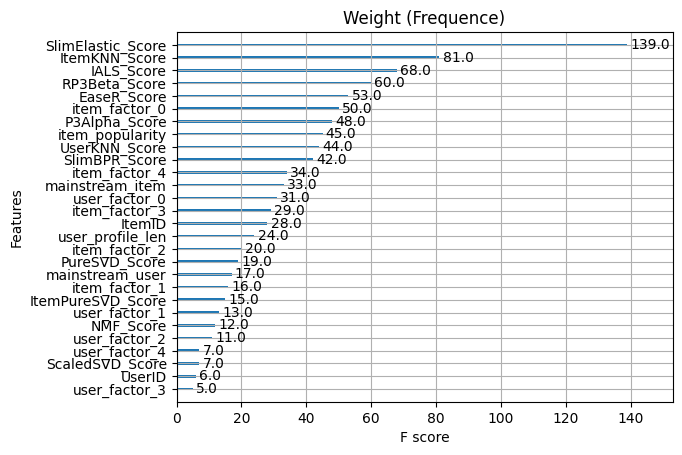

In [59]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [60]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_all)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

# recommender_als = ALSImplicitRecommender(URM_all)
# recommender_als.load_model('/kaggle/working/', 'als_all.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_all, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 22347 (100.0%), 4170.92 column/sec. Elapsed time 5.36 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 13024 (100.0%), 4083.12 column/sec. Elapsed time 3.19 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2249.12 column/sec. Elapsed time 9.94 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 2612.56 column/sec. Elapsed time 8.55 sec
PureSVDRecommender: URM Detected 386 ( 3.0%) users with no inter

In [61]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    # 'ALS': recommender_als
}

In [62]:
cutoff = 50
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        prediction_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
#         rank = np.argsort(linf_scores[user_id, :])[::-1]
#         positions = np.arange(n_items)[rank]
#         prediction_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
#         recommendations = pd.Series(rank[:10]).to_frame(name='ItemID')
#         tmp = pd.merge(prediction_dataframe.loc[user_id, 'ItemID'].to_frame(name='ItemID'), recommendations, on='ItemID', how='left', indicator='Exist')
#         tmp["Recommended"] = tmp["Exist"] == "both"
#         prediction_dataframe.loc[user_id, f"{label}_Recommended"] = tmp["Recommended"].values
    
    del scores, linf_scores # , rank, positions, tmp
    gc.collect()

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
item_popularity = item_popularity / np.max(item_popularity)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
user_popularity = user_popularity / np.max(user_popularity)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_all.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
prediction_dataframe['mainstream_item'] = mainstream_item[prediction_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

prediction_dataframe = prediction_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
prediction_dataframe = prediction_dataframe.sort_values(by='UserID')

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

/tmp/ipykernel_19/3058067735.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,UserKNN_Score,P3Alpha_Score,RP3Beta_Score,NMF_Score,PureSVD_Score,ScaledSVD_Score,ItemPureSVD_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,100,0.999999,0.419887,0.786014,0.850932,0.243131,0.414083,0.346509,0.439719,...,0.045669,0.010442,0.052225,-0.058731,0.022079,0.005573,0.000276,0.007794,-0.010626,-0.001530
27,0,111,0.082615,0.107988,0.000000,0.067880,0.066527,0.222882,0.134390,0.132828,...,0.040914,-0.012057,0.014528,-0.047855,-0.023098,0.005573,0.000276,0.007794,-0.010626,-0.001530
28,0,215,0.180754,0.010770,0.085517,0.119951,0.014132,0.006083,0.016326,0.055792,...,0.035591,0.015862,-0.019037,0.043913,0.006133,0.005573,0.000276,0.007794,-0.010626,-0.001530
29,0,1082,0.257622,0.025246,0.088188,0.122322,0.060595,0.016214,0.042444,0.062910,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
30,0,1337,0.235539,0.007136,0.064524,0.093138,0.023671,0.023861,0.035983,0.036932,...,0.008009,-0.013008,0.019273,0.015060,0.043675,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651189,13023,1238,0.097473,0.442709,0.073992,0.138654,0.266554,0.147914,0.054562,0.120463,...,0.006622,-0.016999,0.013130,0.007500,0.036445,0.009693,-0.007923,-0.000422,0.004503,0.023066
651150,13023,732,0.576149,0.711712,0.773915,0.653700,0.275051,0.178218,0.252762,0.225139,...,0.016157,-0.035325,0.015268,0.016982,0.054950,0.009693,-0.007923,-0.000422,0.004503,0.023066
651180,13023,685,0.047530,0.459579,0.000000,0.000000,0.216338,0.160210,0.178031,0.110504,...,0.010855,-0.026114,0.011748,0.007983,0.029280,0.009693,-0.007923,-0.000422,0.004503,0.023066
651153,13023,2119,0.660220,0.547857,0.593510,0.592051,0.176605,0.080873,0.161751,0.199485,...,0.004605,-0.013688,0.006540,0.004982,0.021528,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [63]:
recommender = XGBoostRerankerRecommender(URM_all, XGB_model, prediction_dataframe)

In [64]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_xgboost.csv', index=False)

,user_id,item_list
0,1,36 101 506 403 123 515 694 1546 52 1422
1,2,1095 12 47 1522 11 50 28 102 656 3176
2,3,59 4252 857 2172 259 584 536 648 1281 956
3,4,249 28 50 7 5 139 314 171 146 254
4,5,1570 77 5138 131 170 1511 471 95 1220 766
